<a href="https://colab.research.google.com/github/Debrup-commits/Face-Emotion-Recognition-CNN/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive Setup and CSV loading**

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/NN\ Tasks/Face\ Emotion\ Recognition/train.csv.zip /content/
!cp /content/drive/MyDrive/NN\ Tasks/Face\ Emotion\ Recognition/test.csv.zip /content/

In [4]:
!unzip -q /content/train.csv.zip
!unzip -q /content/test.csv.zip

# **Dataset Setup**

In [5]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import pdb

class Generate_data():
  def __init__(self, datapath):
    """
        Generate_data class
        Two methods to be used
        1-split_test
        2-save_img
        
    """
    self.data_path = datapath
  
  def split_train(self, train_filename='train_f', val_filename='val'):

    """
        splits the train.csv into final training and validation csv files
        converts the pixel string into images and saves them into respective
        folders for dataset class to work on

    """
    csv_path = self.data_path+"/"+'train.csv'
    train = pd.read_csv(csv_path)

    validation_data = pd.DataFrame(train.iloc[:3588, :])
    train_data = pd.DataFrame(train.iloc[3588:, :])

    train_data.to_csv(self.data_path+"/"+train_filename+'.csv')
    validation_data.to_csv(self.data_path+"/"+val_filename+'.csv')

    print("train.csv split into val.csv(for evaluating) and train_f.csv(for training)")
  
  def str_to_img(self, str_img = ' '):
    # converts image string to image

    img_arr_str = str_img.split(' ')
    img_arr = np.asarray(img_arr_str, dtype=np.uint8).reshape(48, 48)
    return Image.fromarray(img_arr)

  def save_img(self, datatype='test'):
    # saves images into folders
    
    folder_path = self.data_path+"/"+datatype
    csv_path = self.data_path+"/"+datatype+'.csv'

    if not os.path.exists(folder_path):
      os.mkdir(folder_path)
    
    df = pd.read_csv(csv_path)
    image_strings = df['pixels']
    no_of_imgs = len(image_strings)

    for i in tqdm(range(no_of_imgs)):
      img = self.str_to_img(image_strings[i])
      img.save(os.path.join(folder_path, '{}{}.jpg'.format(datatype, i)), 'JPEG')
  
    print("Images saved!")


In [6]:
# splitting the dataset and generating image folders

gd = Generate_data('/content')
gd.split_train()
gd.save_img()
gd.save_img('train_f')
gd.save_img('val')

train.csv split into val.csv(for evaluating) and train_f.csv(for training)


100%|██████████| 7178/7178 [00:04<00:00, 1619.68it/s]


Images saved!


100%|██████████| 25121/25121 [00:16<00:00, 1479.03it/s]


Images saved!


100%|██████████| 3588/3588 [00:02<00:00, 1666.54it/s]

Images saved!


# **Dataset Class**

In [7]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
  def __init__(self, csv_path, img_dir, datatype, transform):
    self.csv_file=pd.read_csv(csv_path)
    self.label = self.csv_file['emotion']
    self.img_dir = img_dir
    self.transform = transform
    self.datatype = datatype

  def __len__(self):
    return len(self.csv_file)
  
  def __getitem__(self, idx):
    if(torch.is_tensor(idx)):
      idx=idx.to_list()

    label=np.array(self.label[idx]);
    label=torch.from_numpy(label).long()
    image=Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
    
    if self.transform:
      image = self.transform(image)

    return image, label

def eval_dataset_class(csv_path, img_dir, datatype, sample_idx, transform=None):
  if transform is None:
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

  dataset=CustomDataset(csv_path, img_dir, datatype, transform)
  image = dataset.__getitem__(sample_idx)[0]
  label = dataset.__getitem__(sample_idx)[1]

  # prints label
  print(label)

  # shows image
  image=image.numpy()
  image=image.squeeze()
  plt.imshow(image)
  plt.show()

tensor(6)


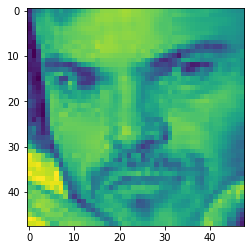

In [8]:
csv_path='/content/train_f.csv'
img_dir='/content/train_f/'
datatype='train_f'
transform=None
eval_dataset_class(csv_path, img_dir, datatype, 100, transform)

# **Our** **Model**

In [9]:
from torch.nn.modules.pooling import MaxPool2d
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
  def __init__(self):

    # inheriting all the methods from the "Module" class
    super(MyModel, self).__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(1, 10, 3)
    self.conv2 = nn.Conv2d(10, 10, 3)
    self.conv3 = nn.Conv2d(10, 10, 3)
    self.conv4 = nn.Conv2d(10, 10, 3)

    # Pooling layers
    self.pool2 = nn.MaxPool2d(2, 2)
    self.pool4 = nn.MaxPool2d(2, 2)

    # Batch normalisation for mormalising inputs
    self.norm = nn.BatchNorm2d(10)

    # fully connected layers
    self.fc1 = nn.Linear(810, 50)
    self.fc2 = nn.Linear(50, 7)

    # The attention Unit/Localisation Network
    self.localisation = nn.Sequential(
        nn.Conv2d(1, 8, 7),
        nn.MaxPool2d(2, stride = 2), #pool1
        nn.ReLU(True),
        nn.Conv2d(8, 10, 5),
        nn.MaxPool2d(2, stride=2), #pool3
        nn.ReLU(True)
    )

    self.fc_loc = nn.Sequential(
        nn.Linear(640, 32),
        nn.ReLU(True),
        nn.Linear(32, 3*2)
    )

    # setting weightss to zero
    self.fc_loc[2].weight.data.zero_()

    # initialising bias
    self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  def LocNet(self, x):
    x_1 = self.localisation(x)
    x_1 = x_1.view(-1, 640) #reshaping
    theta = self.fc_loc(x_1)
    theta = theta.view(-1, 2, 3)
    grid = F.affine_grid(theta, x.size())
    x = F.grid_sample(x, grid)

    return x

  def forward(self, x):
    out = self.LocNet(x)

    # DeepEmotion Network
    # Block1
    out = F.relu(self.conv1(out))
    out = self.conv2(out)
    out = F.relu(self.pool2(out))

    # Block2
    out = F.relu(self.conv3(out))
    out = self.conv4(out)
    out = F.relu(self.pool4(out))

    out = F.dropout(out) #meant to avoid overfitting
    out = out.view(-1, 810)
    out = F.relu(self.fc1(out))
    out = self.fc2(out)

    return out


# **Training**

In [78]:
from __future__ import print_function
import argparse
import numpy  as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def Train(epochs,train_loader,val_loader,criterion,optmizer,device):

    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0

        # Train the model
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        model.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = model(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(val_dataset)
        val_acc = val_correct.double() / len(val_dataset)
        print('Epoch: {}  Training Loss: {:.8f}  Validation Loss: {:.8f}  Training Accuarcy: {:.3f}%  Validation Accuarcy: {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

    print("===================================Training Finished===================================")



In [ ]:
# Training setup
epochs = 100
batchsize = 128
lr = 0.005

model = MyModel()
model.to(device)
         
train_csv_file = '/content/train_f.csv'
val_csv_file = '/content/val.csv'
train_img_dir = '/content/train_f/'
val_img_dir = '/content/val/'

tranfrom = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_dataset= CustomDataset(train_csv_file, train_img_dir, 'train_f', transform)
val_dataset= CustomDataset(val_csv_file, val_img_dir, 'val', transform)
train_loader= DataLoader(train_dataset, batch_size=batchsize, shuffle = True, num_workers=0)
val_loader=   DataLoader(val_dataset, batch_size=batchsize, shuffle = True, num_workers=0)

criterion= nn.CrossEntropyLoss()
optmizer= optim.Adam(model.parameters(),lr= lr)

#Train the model
Train(epochs, train_loader, val_loader, criterion, optmizer, device)

===================================Start Training===================================


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4256: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Epoch: 1  Training Loss: 0.01361557  Validation Loss: 0.01317001  Training Accuarcy: 29.107%  Validation Accuarcy: 34.030%
Epoch: 2  Training Loss: 0.01263842  Validation Loss: 0.01290678  Training Accuarcy: 36.587%  Validation Accuarcy: 38.657%
Epoch: 3  Training Loss: 0.01211292  Validation Loss: 0.01221270  Training Accuarcy: 39.350%  Validation Accuarcy: 40.747%
Epoch: 4  Training Loss: 0.01171700  Validation Loss: 0.01186419  Training Accuarcy: 41.822%  Validation Accuarcy: 43.200%
Epoch: 5  Training Loss: 0.01139309  Validation Loss: 0.01173765  Training Accuarcy: 43.653%  Validation Accuarcy: 43.645%
Epoch: 6  Training Loss: 0.01120902  Validation Loss: 0.01155581  Training Accuarcy: 44.425%  Validation Accuarcy: 44.844%
Epoch: 7  Training Loss: 0.01105450  Validation Loss: 0.01158549  Training Accuarcy: 46.033%  Validation Accuarcy: 44.565%
Epoch: 8  Training Loss: 0.01097155  Validation Loss: 0.01162913  Training Accuarcy: 45.643%  Validation Accuarcy: 44.677%
Epoch: 9  Traini

In [ ]:
torch.save(model.state_dict(), '/content/Deep_Emotion_Model.pt')
torch.save(model.state_dict(), '/content/drive/MyDrive/NN Tasks/Face Emotion Recognition/model.pt')
print("Model saved!")

In [ ]:
model = MyModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/NN Tasks/Face Emotion Recognition/model.pt'))
model.to(device)

# **Visualisation setup**

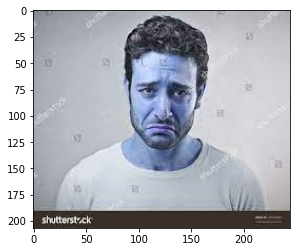

In [38]:
import cv2
import matplotlib.pyplot as plt

frame = cv2.imread('/content/drive/MyDrive/NN Tasks/Face Emotion Recognition/sad man.jpg')
plt.imshow(frame)

In [39]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
face_roi=gray

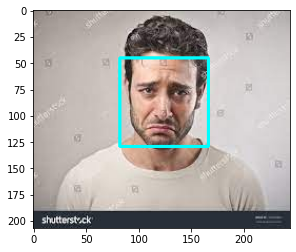

In [40]:
# detect face
faces = face_cascade.detectMultiScale(frame, 1.1, 4)
for x, y, w, h in faces:
  roi_gray=gray[y:y+h, x:x+w]
  roi_color=frame[y:y+h, x:x+w]
  cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)
  facess=face_cascade.detectMultiScale(roi_gray)
  if len(facess)==0:
    print("Face not detected")
  else:
    for(ex, ey, ew, eh) in facess:
      # face region of interest
      face_roi=roi_color[ey:ey+h, ex:ex+w]

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [51]:
gray=cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)

# resize to input dims required by the model
final_img=cv2.resize(gray, (48, 48))

final_img=np.expand_dims(final_img, axis=0) #adds 3rd dimension
final_img=np.expand_dims(final_img, axis=0) #adds 4th dimension


In [52]:
# now img can be fed into the model to judge output
final_img=final_img/255.0 #normalization
data=torch.from_numpy(final_img)
data=data.type(torch.FloatTensor)
data=data.to(device)

In [53]:
# model output

Output=model(data)
pred = F.softmax(Output, dim=1)
index_pred=torch.argmax(pred)

print(index_pred)

tensor(4)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4256: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


# **WEBCAM IMPLEMENTATION**

**Dependencies**

In [63]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

**Helper Functions**

In [64]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

**Webcam access** **setup**

In [65]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [77]:
import cv2
from google.colab.patches import cv_imshow

# Video Cam access achieved via javascript
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
      break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])
  
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

  gray=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  faces=face_cascade.detectMultiScale(gray, 1.1, 4)
  for x, y, w, h in faces:
    roi_gray=gray[y:y+h, x:x+w]
    roi_color=frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 0), 2)
    
  graytemp = cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY)

  final_img=cv2.resize(graytemp, (48, 48))
  final_img=np.expand_dims(final_img, axis=0) #adds 3rd dimension
  final_img=np.expand_dims(final_img, axis=0) #adds 4th dimension
  final_img=final_img/255.0 #normalization

  data=torch.from_numpy(final_img)
  data=data.type(torch.FloatTensor)
  data=data.to(device)

  Output=model(data)
  pred = F.softmax(Output, dim=1)
  index_pred=torch.argmax(pred)

  if index_pred==0:
    status="Angry"
  if index_pred==1:
    status="Disgust"
  if index_pred==2:
    status="Fear"
  if index_pred==3:
    status="Happy"
  if index_pred==4:
    status="Sad"
  if index_pred==5:
    status="Surprise"
  if index_pred==6:
    status="Neutral"
  
  x1, y1, w1, h1 = 0, 0, 175, 75
  font = cv2.FONT_HERSHEY_COMPLEX
  cv2.rectangle(frame, (x1, y1), (x1+w1, y1+h1), (0, 0, 0), -1)
  cv2.putText(frame, status, (x1+int(w1/10), y1+int(h1/2)), font, 0.7, (0, 255, 0), 2)
  cv_imshow(frame)     